# Africa Credit Challenge

The goals of this `starter notebook` are:

1. How to load data into a `Pandas` dataframe

2. How to `train` a basic machine learning model

3. How to `evaluate` the model

4. How to `save` your __submission__ following the required format.

<font color="red"><b>Note: This is just a starter notebook. It is by no means an ideal solution.</b></font>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

## Load and Inspect the data

In [ ]:
# Loading the train dataset
train = pd.read_csv('data/Train.csv')
test = pd.read_csv('data/Test.csv')
# Display the first few rows of the datasets and their shape
pd.set_option('display.max_columns', None)
display("Train", train.head(), train.shape, "Test", test.head(), test.shape)

'Train'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0


(68654, 16)

'Test'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,7,Repeat Loan,575.7,0.300000,597.0
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,7,Repeat Loan,0.0,0.000000,0.0
2,ID_257026243764267278,257026,Kenya,243764,267278,Type_1,8254.0,8304.0,2022-08-24,2022-08-31,7,Repeat Loan,207.0,0.025079,208.0
3,ID_264617299409267278,264617,Kenya,299409,267278,Type_1,3379.0,3379.0,2022-11-15,2022-11-22,7,Repeat Loan,1013.7,0.300000,1014.0
4,ID_247613296713267278,247613,Kenya,296713,267278,Type_1,120.0,120.0,2022-11-10,2022-11-17,7,Repeat Loan,36.0,0.300000,36.0


(18594, 15)

In [3]:
# Check column types & missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           68654 non-null  object 
 1   customer_id                  68654 non-null  int64  
 2   country_id                   68654 non-null  object 
 3   tbl_loan_id                  68654 non-null  int64  
 4   lender_id                    68654 non-null  int64  
 5   loan_type                    68654 non-null  object 
 6   Total_Amount                 68654 non-null  float64
 7   Total_Amount_to_Repay        68654 non-null  float64
 8   disbursement_date            68654 non-null  object 
 9   due_date                     68654 non-null  object 
 10  duration                     68654 non-null  int64  
 11  New_versus_Repeat            68654 non-null  object 
 12  Amount_Funded_By_Lender      68654 non-null  float64
 13  Lender_portion_F

In [4]:
# Are there missing values in the train dataset ?
print(f"There are {train.isna().sum().sum()} missing values in the data.")

There are 0 missing values in the data.


### EDA

In [5]:
def plot_continuous(df, column, transform=None):
    """
    Plots visualizations for a continuous variable, showing the distribution and boxplot for both
    the original and transformed versions of the data.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The column name of the continuous variable to plot.
        transform (str, optional): Transformation to apply to the data before plotting.
                                  Accepted values are 'log' or 'sqrt'. Default is None, which means no transformation.

    This function generates:
        - A histogram with a kernel density estimate (KDE) for the original data.
        - A boxplot for the original data.
        - If a transformation is specified ('log' or 'sqrt'):
            - A histogram with a KDE for the transformed data.
            - A boxplot for the transformed data.
    """
    # Create subplots for visualizations
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))

    # Original data plots
    sns.histplot(df[column], kde=True, ax=axs[0, 0])
    axs[0, 0].set_title(f'Distribution of {column}')
    axs[0, 0].set_xlabel(column)

    sns.boxplot(y=df[column], ax=axs[1, 0])
    axs[1, 0].set_title(f'Box Plot of {column}')
    axs[1, 0].set_ylabel(column)

    # Transformations (log or square root)
    if transform == 'log':
        transformed_data = np.log1p(df[column])  # log1p handles log(0) gracefully
        transform_label = 'Log'
    elif transform == 'sqrt':
        transformed_data = np.sqrt(df[column])  # Square root transformation
        transform_label = 'Square Root'
    else:
        transformed_data = None  # No transformation if not specified

    # If transformed data exists, generate corresponding plots
    if transformed_data is not None:
        sns.histplot(transformed_data, kde=True, ax=axs[0, 1])
        axs[0, 1].set_title(f'{transform_label} Distribution of {column}')
        axs[0, 1].set_xlabel(f'{transform_label}({column})')

        sns.boxplot(y=transformed_data, ax=axs[1, 1])
        axs[1, 1].set_title(f'{transform_label} Box Plot of {column}')
        axs[1, 1].set_ylabel(f'{transform_label}({column})')
    else:
        # If no transformation, remove the second set of axes
        for ax in [axs[0, 1], axs[1, 1]]:
            ax.remove()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


def plot_categorical(df, column):
    """
    Plots visualizations for a categorical variable, including a bar plot and a pie chart.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The column name of the categorical variable to plot.

    This function generates:
        - A bar plot showing the counts of each category in the specified column.
        - A pie chart showing the relative proportions of each category.
    """
    # Create subplots for visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Bar plot showing counts of each category
    value_counts = df[column].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax1)
    ax1.set_title(f'Bar Plot of {column}')
    ax1.set_xlabel(column)
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    # Pie chart showing percentage distribution of each category
    ax2.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
    ax2.set_title(f'Pie Chart of {column}')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


#### Categorical exploration

# Understand the Target Variable
Before we can do anything we first have to understand the column we are trying to predict. 
- The question to answer is: Out of all the loans in our training data, how many actually defaulted?

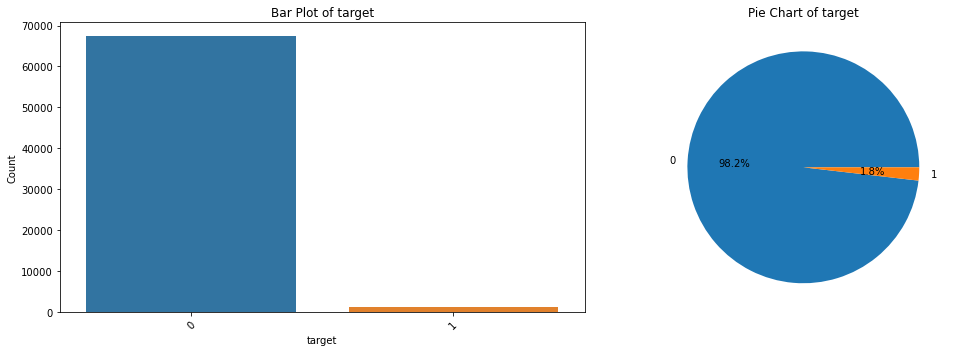

In [6]:
plot_categorical(train, 'target')

## ***Analysis***:
The dataset is highly imbalanced. 
The vast majority of the customers are good(98.2%) 
The real problem is in finding the tiny fraction (1.8%) of customers who will cause the financial institutions to lose money.


## **Consequences of this imbalance**:
- **Evaluation metric**: The F1-score is choosen as it forces our model to get good at predicting both classes and not just the majority class

- **Modeling strategy**: Techniques used to handle the imbalance are:
  - using stratified cross-validation
  - using algorithms that handle imbalance well (e.g., tree-based algorithms)
  - using advanced resampling techniques (e.g., SMOTE, ADASYN)
  - using anomaly detection algorithms (e.g., Isolation Forest, One-Class SVM)
  - using cost-sensitive learning (e.g., adjusting class weights in algorithms like logistic regression, decision trees, and support vector machines)
  - using ensemble methods (e.g., Random Forest, Gradient Boosting) that can handle imbalance better than single models
  - using threshold moving to adjust the decision threshold for classification
  - using evaluation metrics that are more appropriate for imbalanced datasets (e.g., precision, recall, F1-score, ROC-AUC)
  - using data augmentation techniques to generate synthetic samples of the minority class
  - using feature engineering to create new features that can help distinguish between the classes better
  - using domain knowledge to identify important features and relationships in the data that can help improve model performance
  - using hyperparameter tuning to optimize model performance for the imbalanced dataset
  - using cross-validation techniques that are appropriate for imbalanced datasets(e.g., stratified k-fold cross-validation)
  - using ensemble methods that combine multiple models to improve performance on imbalanced datasets (e.g., bagging, boosting)
  - using transfer learning to leverage pre-trained models on similar tasks to improve performance on the imbalanced dataset
  - using active learning to iteratively select the most informative samples for labeling and training the model
  - using semi-supervised learning to leverage both labeled and unlabeled data to improve model performance on the imbalanced dataset
  - using deep learning techniques that can handle imbalanced datasets (e.g., convolutional neural networks, recurrent neural networks)
  - using explainable AI techniques to understand how the model is making predictions and identify potential biases in the data
  - using regularization techniques to prevent overfitting and improve generalization on the imbalanced dataset
  - data cleaning to remove noise and outliers that can negatively impoct model performance on the imbalanced dataset
  - using feature selection techniques to identify the most importnant features for the imbalanced dataset
  - data visualization that can help identify patterns and relationships in the data that can improve model performance on the imbalanced dataset.
  - using ensemble methods that combine multiple techniques to improve performance on imbalanced datasets (e.g., SMOTE + cost-sensitive learning + ensemble methods)
  - using a combination of the above techniques to improve model performance on the imbalanced dataset. 

In [7]:
# Assume 'train_df' is your loaded training DataFrame

# Select columns with numerical data types
numerical_features = train.select_dtypes(include=['int64', 'float64']).columns
num_numerical_features = len(numerical_features)

# Select columns with categorical/text data types
categorical_features = train.select_dtypes(include=['object']).columns
num_categorical_features = len(categorical_features)

print(f"Found {num_numerical_features} numerical features:")
print(list(numerical_features))

print("\n------------------------------------\n")

print(f"Found {num_categorical_features} categorical features:")
print(list(categorical_features))

Found 10 numerical features:
['customer_id', 'tbl_loan_id', 'lender_id', 'Total_Amount', 'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'Lender_portion_to_be_repaid', 'target']

------------------------------------

Found 6 categorical features:
['ID', 'country_id', 'loan_type', 'disbursement_date', 'due_date', 'New_versus_Repeat']


## **Find predictive Signal (Numerical Feature vs. Target)**
We investigate the relationship between each numerical feature and the target variable to see which are most predictive of loan default. 

- For which of our features do defaulters look the most different from people who pay back?


In [8]:
# Identify numerical columns (excluding IDs and the target itself)
numerical_cols = train.select_dtypes(include=['number']).columns.drop(['customer_id', 'tbl_loan_id', 'lender_id', 'target'])

# Group by target and calculate the mean for each numerical column
grouped_stats = train.groupby('target')[numerical_cols].mean()

# Calculate the absolute difference in means between the two target classes
mean_difference = abs(grouped_stats.loc[0] - grouped_stats.loc[1])

# Sort the features by the difference in their means
sorted_differences = mean_difference.sort_values(ascending=False)

# Display the results
print("Features with the largest difference in mean between Defaulters and Non-Defaulters:")
print(sorted_differences)

Features with the largest difference in mean between Defaulters and Non-Defaulters:
Total_Amount_to_Repay          107190.593765
Total_Amount                    90873.954680
Lender_portion_to_be_repaid     10925.598099
Amount_Funded_By_Lender          9053.549695
duration                           18.891401
Lender_portion_Funded               0.043966
dtype: float64


## Visualizing the differences

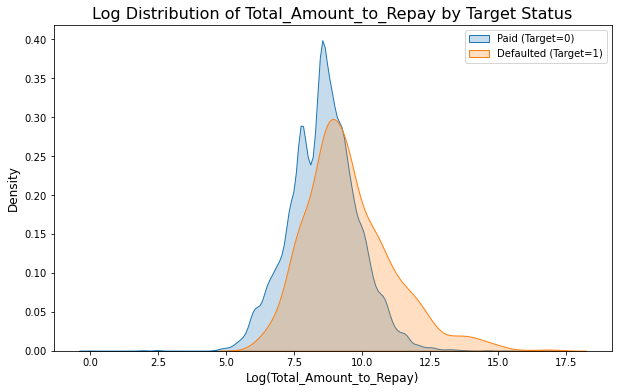

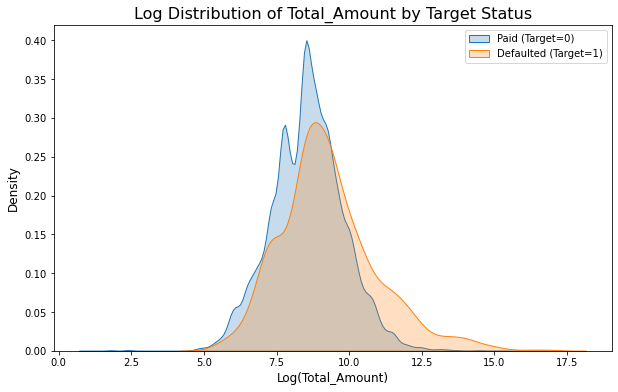

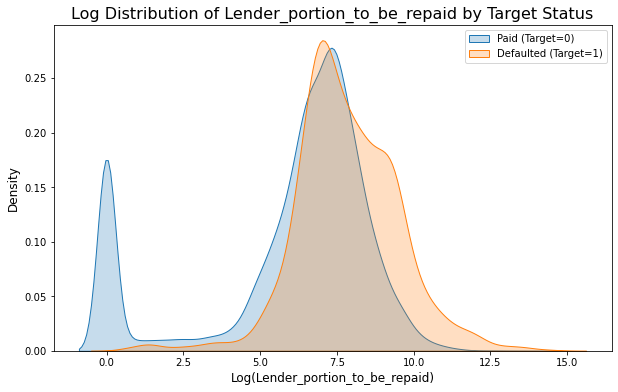

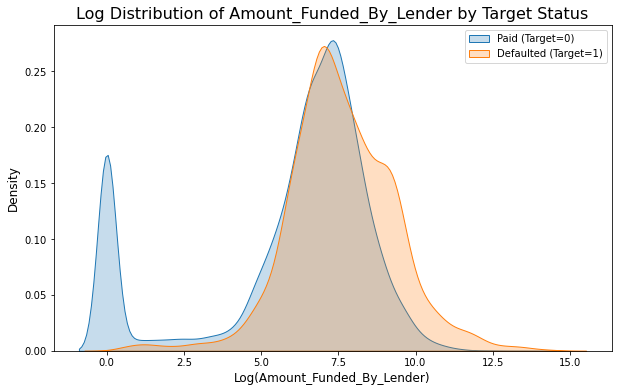

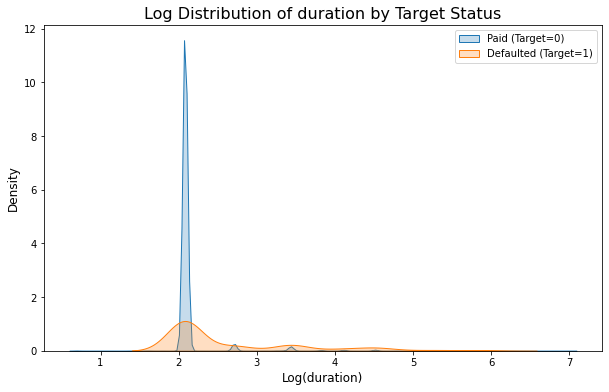

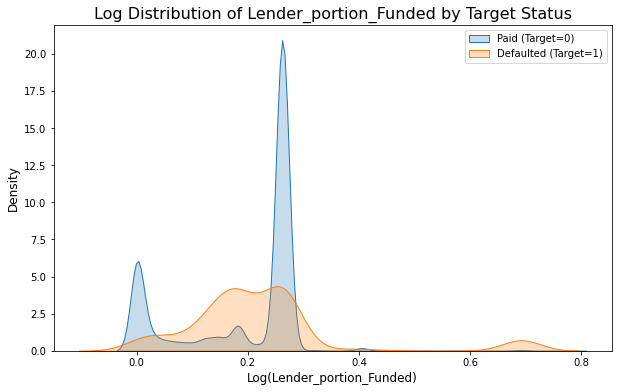

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# The list of numerical features we want to investigate
features_to_plot = [
    'Total_Amount_to_Repay',
    'Total_Amount',
    'Lender_portion_to_be_repaid',
    'Amount_Funded_By_Lender',
    'duration',
    'Lender_portion_Funded'
]

# Loop through each feature and plot its log distribution
for col in features_to_plot:
    plt.figure(figsize=(10, 6))
    
    # Apply log transformation to the column for both groups
    sns.kdeplot(np.log1p(train[train['target'] == 0][col]), label='Paid (Target=0)', shade=True)
    sns.kdeplot(np.log1p(train[train['target'] == 1][col]), label='Defaulted (Target=1)', shade=True)
    
    # Update title and labels to reflect the transformation
    plt.title(f'Log Distribution of {col} by Target Status', fontsize=16)
    plt.xlabel(f'Log({col})', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.show()


#### **Overall Finding**

The exploratory data analysis reveals clear differences in the distributions of several key numerical features between loans that were paid back (Target=0) and loans that defaulted (Target=1). By plotting these features on a logarithmic scale, we can overcome the data skewness and identify strong predictive signals that will be crucial for our machine learning model.


#### **1. Loan Amounts (Total_Amount & Total_Amount_to_Repay)**

- **Observation:** The distributions for the "Paid" group (blue) are narrower and have a higher peak at a lower loan amount compared to the "Defaulted" group (orange). The orange curve is flatter and shifted to the right, indicating a wider range of loan amounts and a tendency towards higher amounts.
    
- **Business Takeaway:** **Customers who default tend to take out larger loans on average than customers who pay back.** The higher the loan amount, the higher the potential risk. This is a very strong and intuitive predictor for our model.
    

#### **2. Loan Duration (duration)**

- **Observation:** The "Paid" group (blue) shows an extremely sharp and high peak at a Log(duration) of around 2.0 (which corresponds to a duration of approx. 7 days, since e^2 ≈ 7.4). The "Defaulted" group (orange) has a much lower, wider peak and a thicker "tail," indicating that defaults occur across a wider range of loan durations.
    
- **Business Takeaway:** **The vast majority of successful loans are very short-term (around 7 days).** While defaults also happen with short-term loans, a longer loan duration is a significant risk factor.
    


#### **3. Lender Funding (Amount_Funded_By_Lender & Lender_portion_to_be_repaid)**

- **Observation:** This is a very interesting pattern. The "Paid" group (blue) has a distinct peak at Log(Amount) equal to 0 (which means the original amount was 0), and then another larger peak around 7-8. The "Defaulted" group (orange) has almost no density at 0 and its main peak is slightly to the right of the "Paid" group's main peak.
    
- **Business Takeaway:** **Loans where the lender funded little to nothing (Amount ≈ 0) are very likely to be paid back.** When the lender does fund an amount, defaulters tend to have slightly higher amounts funded by the lender than non-defaulters.
    


#### **4. Lender Portion Funded (Lender_portion_Funded)**

- **Observation:** This plot is now much clearer. The "Paid" group (blue) has three distinct behaviors: a peak near 0, another small peak, and a very large peak around Log(0.3) which is approx -1.2. The "Defaulted" group (orange) has a wider, more spread-out distribution.
    
- **Business Takeaway:** The funding strategy appears to be a key indicator. **Customers who default have a more varied and less predictable lender funding portion.** In contrast, good customers seem to fall into very specific funding brackets.
    


In [10]:
# Display the unique value counts and their sum for each categorical feature in the train dataset

categorical_features = train.select_dtypes(include=['object']).columns

for col in categorical_features:
    value_counts = train[col].value_counts()
    print(f"Column: {col}")
    print(value_counts)
    print(f"Number of unique values: {train[col].nunique()}")
    print("-" * 40)

Column: ID
ID_257162303238267278    1
ID_246773276686267278    1
ID_249371232390267278    1
ID_259525238352267278    1
ID_258912217681267278    1
                        ..
ID_251850282947267278    1
ID_247947238027267278    1
ID_252906238495267278    1
ID_269385254834267278    1
ID_263412256999267278    1
Name: ID, Length: 68654, dtype: int64
Number of unique values: 68654
----------------------------------------
Column: country_id
Kenya    68654
Name: country_id, dtype: int64
Number of unique values: 1
----------------------------------------
Column: loan_type
Type_1     61723
Type_7      2790
Type_5      1521
Type_4      1235
Type_10      466
Type_6       357
Type_9       205
Type_14       99
Type_2        74
Type_11       42
Type_18       30
Type_17       23
Type_12       21
Type_23       18
Type_20       13
Type_16       12
Type_13       10
Type_19        4
Type_15        4
Type_21        3
Type_24        3
Type_22        1
Name: loan_type, dtype: int64
Number of unique values: 22

### **Find a Predictive Signal (Categorical Feature vs. Target)**
- Just like with numerical features, we want to know if the proportion of defaulters is different acros various categories.

Business question: 
- Are customers who are New more or less likely to default than customers who are Repeat? 
- Are certain loan types riskier than others?

Analyzing the following categorical features: ['loan_type', 'New_versus_Repeat']


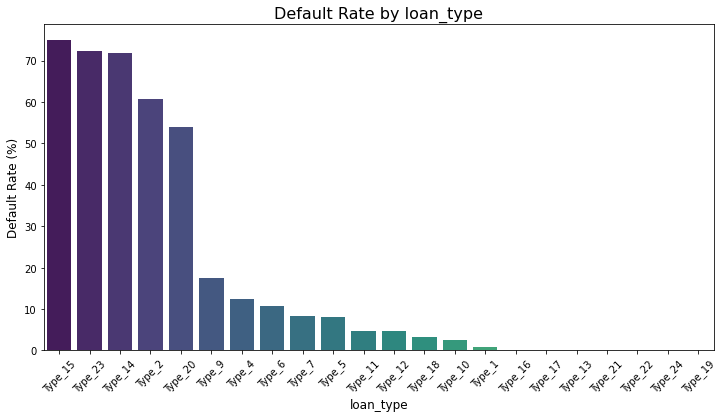

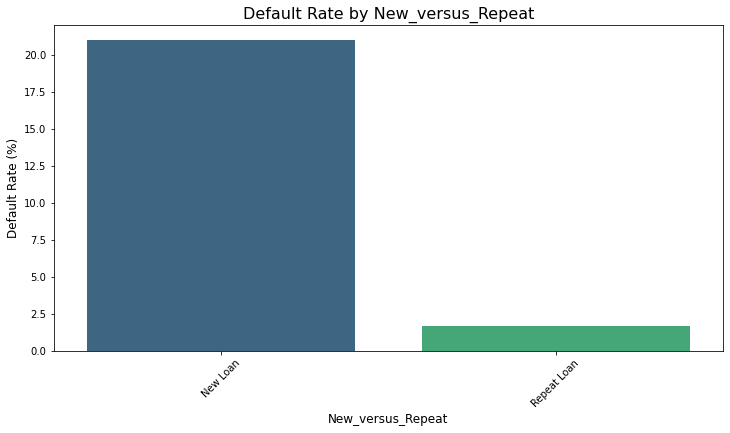

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_categorical_vs_target(df, column_name):
    """
    Plots the default rate (percentage of target=1) for each category 
    of a specified column.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the categorical column to plot.
    """
    plt.figure(figsize=(12, 6))
    
    # Calculate the default rate for each category and sort it
    default_rate = df.groupby(column_name)['target'].mean().sort_values(ascending=False) * 100
    
    # Create the bar plot
    sns.barplot(x=default_rate.index, y=default_rate.values, palette="viridis")
    
    plt.title(f'Default Rate by {column_name}', fontsize=16)
    plt.xlabel(column_name, fontsize=12)
    plt.ylabel('Default Rate (%)', fontsize=12)
    plt.xticks(rotation=45) 
    plt.show()

# --- Now, let's use the function ---

# First, get a list of all categorical columns
all_categorical_features = train.select_dtypes(include=['object']).columns

# Create a list of features to plot.
# We exclude columns like 'ID' because they have too many unique values to be useful here,
# and we already know 'country_id' only has one value in the training set.
# The date columns are also not suitable for this type of bar chart.    
features_to_plot = ['loan_type', 'New_versus_Repeat']


# Loop through our list of relevant categorical features and create a plot for each
print(f"Analyzing the following categorical features: {features_to_plot}")
for col in features_to_plot:
    plot_categorical_vs_target(train, col)

## ***Analyze Categorical Features***

Analysis of the key categorical features reveals strong relationships between the loan characteristics and the probability of default. These features will be highly valuable for our predictive model.


#### **1. Default Rate by New_versus_Repeat**

- **Observation:** The bar chart shows a dramatic difference in default rates. "New Loan" customers have a default rate of over **20%**, while "Repeat Loan" customers have a default rate of less than **2%**.
    
- **Business Takeaway:** This is arguably the **strongest single predictor of risk** we have seen so far. Customers with no prior borrowing history with the lender are more than **10 times more likely to default** than existing customers. Our model must pay very close attention to this feature. It confirms the common business wisdom that past performance is a key indicator of future reliability.
    

#### **2. Default Rate by loan_type**

- **Observation:** There is a very wide variance in risk across different loan types.
    
    - **High-Risk Loans:** Type_15, Type_23, and Type_14 have extremely high default rates, exceeding **70%**. Type_2 and Type_20 are also very high-risk, with default rates over 50%.
        
    - **Low-Risk Loans:** Type_1, which is the most common loan type in the dataset, has a very low default rate (close to 1%). Many other loan types (Type_16, Type_17, etc.) have a 0% default rate in the training data, though this might be due to having very few samples.
        
- **Business Takeaway:** The specific product or type of loan a customer applies for is a critical indicator of risk. The model can learn to assign a much higher risk score to customers applying for Type_15 or Type_23 loans compared to the much safer Type_1 loans. This information could be used by the business to either tighten lending criteria for high-risk products or to re-evaluate the profitability of offering them at all.

## **FEATURE ENGINEERING**
### **DATE-BASED FEATURES**

- The disbursement_date and due_date columns are not useful in their raw form. However, we can extract meaningful features from them that may help our model.

#### **Data validation**
- we have a duration column but calculating it ourselves from the dates allows us to check for any inconsistencies which could be a very interesting signal on their own.

**operations to perform**
- combine data into one master dataframe: to ensure we create the same features for both train and test data
- convert to datetime format
- create the features

In [12]:
# Make sure you have the original train and test dataframes loaded
# train = pd.read_csv('Train.csv')
# test = pd.read_csv('Test.csv')

# Step 1: Combine the datasets
# We add a 'source' column to remember which row came from where
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train, test], ignore_index=True)


# Step 2: Convert date columns to datetime objects
data['disbursement_date'] = pd.to_datetime(data['disbursement_date'])
data['due_date'] = pd.to_datetime(data['due_date'])


# Step 3: Create a new feature for the calculated duration in days
data['repayment_duration_days'] = (data['due_date'] - data['disbursement_date']).dt.days


# Display the first few rows with the new column to verify
print("New feature 'repayment_duration_days' created.")
display(data[['disbursement_date', 'due_date', 'duration', 'repayment_duration_days']].head(1))

# Calculate the difference between the two duration columns
data['duration_difference'] = data['repayment_duration_days'] - data['duration']

# Find out how many rows have a non-zero difference
num_inconsistencies = data[data['duration_difference'] != 0].shape[0]

print(f"Found {num_inconsistencies} rows where the calculated duration does not match the 'duration' column.")

# If there are inconsistencies, let's look at a few of them
if num_inconsistencies > 0:
    print("\n--- Examples of Inconsistent Durations ---")
    # Display the relevant columns for the inconsistent rows
    print(data[data['duration_difference'] != 0][[
        'disbursement_date', 
        'due_date', 
        'duration', 
        'repayment_duration_days', 
        'duration_difference'
    ]].head())

New feature 'repayment_duration_days' created.


,disbursement_date,due_date,duration,repayment_duration_days
0,2022-08-30,2022-09-06,7,7


Found 0 rows where the calculated duration does not match the 'duration' column.


### **Seasonality and trends**
- Information like the month, day of the week or year can be very predictive. we create these features from the disbursement_date and not due_date because due_date is information from the future while disbursement_date is known at the time of application.
- Are defaults more common in certain months or on certain days of the week?


In [13]:

# Extract time-based features from the disbursement_date
data['disbursement_month'] = data['disbursement_date'].dt.month
data['disbursement_day_of_week'] = data['disbursement_date'].dt.dayofweek # Monday=0, Sunday=6
data['disbursement_year'] = data['disbursement_date'].dt.year

# Now that we have extracted all the useful info, we can drop the original date columns
# and our temporary validation columns
columns_to_drop = ['disbursement_date', 'due_date', 'repayment_duration_days', 'duration_difference']
data = data.drop(columns=columns_to_drop)

# Display the first few rows with the NEW features to verify
print("Created new date-based features and dropped original date columns.")
display(data[['disbursement_month', 'disbursement_day_of_week', 'disbursement_year']].head())

Created new date-based features and dropped original date columns.


,disbursement_month,disbursement_day_of_week,disbursement_year
0,8,1,2022
1,7,5,2022
2,9,4,2024
3,10,3,2022
4,11,0,2022


### **Customer-Level Aggregation Features**
- Does a customer's borrowing history (like how many loans they've taken before, their average loan size, etc.) influence their risk of defaulting on a new loan?"
Intuitively, we know the answer is yes. A customer with a long history of successfully paying back loans is very different from a brand new customer. We need to create features that explicitly give this historical context to our model.

- we use `groupby` and `agg()` methods to create these features. we'll group our entire data by customer_id. for each customer we calc statistics like: the total number of loans they've had, their average loan amount, and standard deviation of their loan amounts. Then merge these new features back into our main dataframe.

In [14]:
# Define the aggregations we want to perform for each customer
customer_aggregations = {
    'Total_Amount': ['mean', 'sum', 'std'], # Average, total, and std dev of loan amount
    'duration': ['mean', 'max'],           # Average and longest loan duration
    'loan_type': ['count']                  # This will give us the number of loans
}

# Group by customer_id and calculate the aggregations
customer_features = data.groupby('customer_id').agg(customer_aggregations)

# The column names will be hierarchical (e.g., ('Total_Amount', 'mean')). 
# Let's flatten them into single names (e.g., 'customer_Total_Amount_mean')
customer_features.columns = ['customer_' + col[0] + '_' + col[1] for col in customer_features.columns]

# Now, merge these new features back into our main dataframe
data = data.merge(customer_features, on='customer_id', how='left')

# Display the first few rows with some of the new columns to verify
print("Created new customer-level aggregation features.")
new_feature_cols = [
    'customer_id',
    'customer_Total_Amount_mean',
    'customer_Total_Amount_sum',
    'customer_Total_Amount_std',
    'customer_duration_mean',
    'customer_duration_max',
    'customer_loan_type_count'
]
print(data[new_feature_cols].head())


Created new customer-level aggregation features.
   customer_id  customer_Total_Amount_mean  customer_Total_Amount_sum  \
0       266671                 7374.753425                   538357.0   
1       248919                20532.260870                   472242.0   
2       308486                 6575.000000                    78900.0   
3       266004                 5531.300000                   110626.0   
4       253803                 3555.551724                   103111.0   

   customer_Total_Amount_std  customer_duration_mean  customer_duration_max  \
0                3461.627547                     7.0                      7   
1               12860.646556                     7.0                      7   
2                1503.254046                     7.0                      7   
3                2246.972328                     7.0                      7   
4                1794.079740                     7.0                      7   

   customer_loan_type_count  
0      

## Handle missing values 
That were created during feature engineering
- The `customer_Total_Amount_std` has **1259 missing values**. These missing values correspond to the 1259 customers in the dataset who have only taken one loan. You cannot calculate a standard deviation (`std`) for a single data point, so pandas correctly fills it with `NaN

In [15]:
# display missing values 
data.isnull().sum()
# display only the columns with missing values
data.isnull().sum()[data.isnull().sum() > 0]

target                       18594
customer_Total_Amount_std     1259
dtype: int64

In [16]:
# Fill missing values
if 'customer_Total_Amount_std' in data.columns:
    data['customer_Total_Amount_std'] = data['customer_Total_Amount_std'].fillna(0)

In [17]:
# validate there is no missing values(except for the target)
data.isnull().sum()[data.isnull().sum() > 0]

target    18594
dtype: int64

### One-Hot Encode Categorical Features

In [33]:
# --- ONE-HOT ENCODING STEP ---

# Identify the categorical columns that are suitable for one-hot encoding
# (We exclude ID and our temporary 'source' column)
categorical_cols_to_encode = [
    col for col in data.select_dtypes(include=['object']).columns 
    if col not in ['ID', 'source']
]

# We also want to one-hot encode 'New_versus_Repeat' even though it might be a number (0/1) already
# This makes our intent clear
if 'New_versus_Repeat' not in categorical_cols_to_encode:
    categorical_cols_to_encode.append('New_versus_Repeat')

print(f"Columns to be One-Hot Encoded: {categorical_cols_to_encode}")

# Perform one-hot encoding
# The 'drop_first=True' argument is a good practice to avoid multicollinearity,
# which can be an issue for some models like Logistic Regression.
data_encoded = pd.get_dummies(data, columns=categorical_cols_to_encode, drop_first=True)

# rename the New_versus_Repeat_Repeat Loan for better clarity
data_encoded.rename(columns={'New_versus_Repeat_Repeat Loan': 'is_repeat_loan'}, inplace=True)
# Let's look at the result
print("\n--- Dataframe after One-Hot Encoding ---")
print("Original shape:", data.shape)
print("New shape:", data_encoded.shape)

# Find the new columns that were created
new_ohe_columns = [col for col in data_encoded.columns if 'loan_type_' in col or 'is_repeat_loan' in col]
print("\nExample of new columns created:")
display(data_encoded[new_ohe_columns].head())

Columns to be One-Hot Encoded: ['country_id', 'loan_type', 'New_versus_Repeat']

--- Dataframe after One-Hot Encoding ---
Original shape: (87248, 24)
New shape: (87248, 46)

Example of new columns created:


,customer_loan_type_count,loan_type_Type_10,loan_type_Type_11,loan_type_Type_12,loan_type_Type_13,loan_type_Type_14,loan_type_Type_15,loan_type_Type_16,loan_type_Type_17,loan_type_Type_18,loan_type_Type_19,loan_type_Type_2,loan_type_Type_20,loan_type_Type_21,loan_type_Type_22,loan_type_Type_23,loan_type_Type_24,loan_type_Type_3,loan_type_Type_4,loan_type_Type_5,loan_type_Type_6,loan_type_Type_7,loan_type_Type_8,loan_type_Type_9,is_repeat_loan
0,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


###  Separate back into final Train and Test sets

In [30]:
# --- FINAL DATA SPLITTING BLOCK ---

# Use the 'source' column to split the data
final_train_df = data_encoded[data_encoded['source'] == 'train'].copy()
final_test_df = data_encoded[data_encoded['source'] == 'test'].copy()

# Now that we've used the 'source' column for its purpose, we can drop it
# from both dataframes so it doesn't get used as a feature in the model.
final_train_df = final_train_df.drop(columns=['source'])
final_test_df = final_test_df.drop(columns=['source', 'target'])


# --- Verification ---
print("--- Data Splitting Complete ---")
print("Shape of original train:", train.shape)
print("Shape of final_train_df:", final_train_df.shape)
print("\nShape of original test:", test.shape)
print("Shape of final_test_df:", final_test_df.shape)

print("\nTarget variable is present in final_train_df:", 'target' in final_train_df.columns)
print("Target variable is present in final_test_df:", 'target' in final_test_df.columns)

--- Data Splitting Complete ---
Shape of original train: (68654, 17)
Shape of final_train_df: (68654, 45)

Shape of original test: (18594, 16)
Shape of final_test_df: (18594, 44)

Target variable is present in final_train_df: True
Target variable is present in final_test_df: False


In [31]:
#display all the columns of final_train_df

final_train_df.columns, final_test_df.columns

(Index(['ID', 'customer_id', 'tbl_loan_id', 'lender_id', 'Total_Amount',
        'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender',
        'Lender_portion_Funded', 'Lender_portion_to_be_repaid', 'target',
        'disbursement_month', 'disbursement_day_of_week', 'disbursement_year',
        'customer_Total_Amount_mean', 'customer_Total_Amount_sum',
        'customer_Total_Amount_std', 'customer_duration_mean',
        'customer_duration_max', 'customer_loan_type_count', 'country_id_Kenya',
        'loan_type_Type_10', 'loan_type_Type_11', 'loan_type_Type_12',
        'loan_type_Type_13', 'loan_type_Type_14', 'loan_type_Type_15',
        'loan_type_Type_16', 'loan_type_Type_17', 'loan_type_Type_18',
        'loan_type_Type_19', 'loan_type_Type_2', 'loan_type_Type_20',
        'loan_type_Type_21', 'loan_type_Type_22', 'loan_type_Type_23',
        'loan_type_Type_24', 'loan_type_Type_3', 'loan_type_Type_4',
        'loan_type_Type_5', 'loan_type_Type_6', 'loan_type_Type_7',


In [52]:
# check if the columns of final_train_df and final_test_df are the same(except for the target column)
set(final_train_df.drop(columns=['target']).columns) == set(final_test_df.columns)

True

In [32]:
final_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68654 entries, 0 to 68653
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           68654 non-null  object 
 1   customer_id                  68654 non-null  int64  
 2   tbl_loan_id                  68654 non-null  int64  
 3   lender_id                    68654 non-null  int64  
 4   Total_Amount                 68654 non-null  float64
 5   Total_Amount_to_Repay        68654 non-null  float64
 6   duration                     68654 non-null  int64  
 7   Amount_Funded_By_Lender      68654 non-null  float64
 8   Lender_portion_Funded        68654 non-null  float64
 9   Lender_portion_to_be_repaid  68654 non-null  float64
 10  target                       68654 non-null  float64
 11  disbursement_month           68654 non-null  int64  
 12  disbursement_day_of_week     68654 non-null  int64  
 13  disbursement_yea

# MODELING

- **Business question:** How can we measure our model's performance in a way that is reliable and gives us confidence that it will work well on new unseen data like the Ghanaian test set?

- We use stratified k-fold cross-validation  which ensures that each fold has the same proportion of defaulters as the overall dataset.

In [34]:
# --- Define Final Features for Modeling ---

# Correctly define the columns to remove from our feature set
# These are identifiers or the target variable itself
cols_to_remove = [
    'ID', 
    'target', 
    'customer_id', 
    'tbl_loan_id', 
    'lender_id'
]

# Create the final list of feature names
final_features = [col for col in final_train_df.columns if col not in cols_to_remove]

# Create our feature matrix (X) and target vector (y)
X = final_train_df[final_features]
y = final_train_df['target']

print(f"Ready for modeling.")
print(f"Shape of feature matrix X: {X.shape}")
print(f"Shape of target vector y: {y.shape}")

Ready for modeling.
Shape of feature matrix X: (68654, 40)
Shape of target vector y: (68654,)


## Baseline Model Training with Cross-Validation
**Business Question:** "Using a simple, standard model, what is the initial F1-score we can achieve on this problem? This will be our baseline to beat."

In [36]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# --- Baseline Modeling with Cross-Validation ---

# Set up the StratifiedKFold
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Create an empty list to store the F1 scores from each fold
f1_scores = []

# Start the cross-validation loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"--- Training Fold {fold+1} ---")
    
    # Split data for this fold
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Train the model
    model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)
    
    # Make predictions and evaluate
    preds = model.predict(X_val_scaled)
    fold_f1 = f1_score(y_val, preds)
    f1_scores.append(fold_f1)
    
    print(f"F1 Score for Fold {fold+1}: {fold_f1:.4f}")

--- Training Fold 1 ---
F1 Score for Fold 1: 0.2293
--- Training Fold 2 ---
F1 Score for Fold 2: 0.2275
--- Training Fold 3 ---
F1 Score for Fold 3: 0.2265
--- Training Fold 4 ---
F1 Score for Fold 4: 0.2194
--- Training Fold 5 ---
F1 Score for Fold 5: 0.2249


In [37]:
# --- Display Final Cross-Validation Results ---

print(f"Average F1 Score across {N_SPLITS} folds: {np.mean(f1_scores):.4f}")
print(f"Standard Deviation of F1 Scores: {np.std(f1_scores):.4f}")

Average F1 Score across 5 folds: 0.2255
Standard Deviation of F1 Scores: 0.0034


### ***Analysis of the baseline model:***
- Average F1-score of 0.2255. This is the score to beat. Our new goal is to improve upon this. 
- Standard deviation of 0.0034 - a low standard deviation is a good sign . it means that the model's performance was very consistent across all 5 folds on the data. This gives us confidence that the baseline's score was stable and a reliable measure of this model's performance.

# TEST prediction and submission
- To get the best possible submission file for the competition, we train our model on the entire training dataset and then make predictions on the test set. 

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# --- CREATE SUBMISSION FILE FOR TEST SET ---

# Step 1: Define the full training set (X, y) and the final test set
X_train_full = final_train_df[final_features]
y_train_full = final_train_df['target']
X_test = final_test_df[final_features]

# Ensure the columns in the test set match the training set exactly
X_test = X_test[X_train_full.columns]


# Step 2: Scale the data
# IMPORTANT: Fit the scaler on the FULL training data
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)


# Step 3: Train the final model on ALL available training data
print("Training the final Logistic Regression model...")
final_baseline_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
final_baseline_model.fit(X_train_full_scaled, y_train_full)
print("Model training complete.")


# Step 4: Make predictions on the scaled test data
print("Making predictions on the test set...")
test_set_predictions = final_baseline_model.predict(X_test_scaled)


# Step 5: Create and save the submission file
submission_df = pd.DataFrame({
    'ID': final_test_df['ID'], 
    'target': test_set_predictions
})

submission_df.to_csv('logistic_regression_submission.csv', index=False)

print("\nFile 'logistic_regression_submission.csv' has been created.")
print("Submission file head:")
print(submission_df.head())

Training the final Logistic Regression model...
Model training complete.
Making predictions on the test set...

File 'logistic_regression_submission.csv' has been created.
Submission file head:
                          ID  target
68654  ID_269404226088267278     1.0
68655  ID_255356300042267278     0.0
68656  ID_257026243764267278     0.0
68657  ID_264617299409267278     0.0
68658  ID_247613296713267278     0.0


## RANDOM FOREST CLASSIFIER

In [39]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier # Import the Random Forest model
from sklearn.metrics import f1_score
import numpy as np

# --- RANDOM FOREST MODELING WITH CROSS-VALIDATION ---

# We will use the same X and y dataframes defined in Step 9.1

# Set up the Cross-Validation loop
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Create a new list to store the F1 scores for this model
rf_f1_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n--- Training Fold {fold+1} ---")
    
    # Split data for this fold
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    # --- Model Training ---
    # We use class_weight='balanced' to handle the imbalanced data.
    # n_jobs=-1 tells the model to use all available CPU cores to speed up training.
    model = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
    
    model.fit(X_train, y_train)
    
    # --- Prediction & Evaluation ---
    preds = model.predict(X_val)
    fold_f1 = f1_score(y_val, preds)
    rf_f1_scores.append(fold_f1)
    
    print(f"F1 Score for Fold {fold+1}: {fold_f1:.4f}")

# --- Final Result ---
print("\n------------------------------------")
print(f"Average F1 Score (Random Forest) across {N_SPLITS} folds: {np.mean(rf_f1_scores):.4f}")
print("Standard Deviation of F1 Scores (Random Forest): " f"{np.std(rf_f1_scores):.4f}")


--- Training Fold 1 ---
F1 Score for Fold 1: 0.5668

--- Training Fold 2 ---
F1 Score for Fold 2: 0.5628

--- Training Fold 3 ---
F1 Score for Fold 3: 0.5565

--- Training Fold 4 ---
F1 Score for Fold 4: 0.5942

--- Training Fold 5 ---
F1 Score for Fold 5: 0.5770

------------------------------------
Average F1 Score (Random Forest) across 5 folds: 0.5715
Standard Deviation of F1 Scores (Random Forest): 0.0132


### ***Analysis of Random Forest Results***
**Average F1 Score: 0.5715:** This is a massive leap from our Logistic Regression baseline of 0.2255. You have more than doubled the performance of the model. This is a clear and powerful demonstration of the value of using a more complex algorithm. The non-linear patterns that Random Forest can capture are clearly very important in this dataset.

**Standard Deviation of Scores: 0.0132:** Again, this is a beautifully low number. It shows that this high performance is stable and consistent across all folds of the data. We can be confident that this score is a true reflection of the model's capability.

In [40]:
from sklearn.ensemble import RandomForestClassifier

# --- CREATE RANDOM FOREST SUBMISSION FILE ---

# Step 12.1: Define the full training set (X, y) and the final test set
# We use the same 'final_features', 'final_train_df', and 'final_test_df' from before
X_train_full = final_train_df[final_features]
y_train_full = final_train_df['target']
X_test = final_test_df[final_features]

# Align columns to ensure they match perfectly
X_test = X_test[X_train_full.columns]


# Step 12.2: Train the final Random Forest model on ALL training data
print("Training the final Random Forest model on all training data...")
final_rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
final_rf_model.fit(X_train_full, y_train_full)
print("Model training complete.")


# Step 12.3: Make predictions on the test data
print("Making predictions on the test set...")
test_set_predictions = final_rf_model.predict(X_test)


# Step 12.4: Create and save the submission file
submission_df = pd.DataFrame({
    'ID': final_test_df['ID'], 
    'target': test_set_predictions
})

submission_df.to_csv('random_forest_submission.csv', index=False)

print("\nFile 'random_forest_submission.csv' has been created.")
print("Submission file head:")
print(submission_df.head())

Training the final Random Forest model on all training data...
Model training complete.
Making predictions on the test set...

File 'random_forest_submission.csv' has been created.
Submission file head:
                          ID  target
68654  ID_269404226088267278     0.0
68655  ID_255356300042267278     0.0
68656  ID_257026243764267278     0.0
68657  ID_264617299409267278     0.0
68658  ID_247613296713267278     0.0


### **Training a Powerful Gradient Booster - XGBoost**
- The Business Question: "Can an industry-standard gradient boosting model like XGBoost, known for its high performance, improve our F1-score and potentially generalize better than the Random Forest model?"
XGBoost is famous in the data science community for its power and flexibility. 

In [44]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier # Import the XGBoost model
from sklearn.metrics import f1_score
import numpy as np
import warnings
warnings.filterwarnings('ignore') 

# --- XGBOOST MODELING WITH CROSS-VALIDATION ---

# We will use the same X and y dataframes defined in Step 9.1

# Set up the Cross-Validation loop
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Create a new list to store the F1 scores
xgb_f1_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n--- Training Fold {fold+1} ---")
    
    # Split data for this fold
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    # --- Model Training ---
    # XGBoost also uses 'scale_pos_weight' for class imbalance.
    ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

    model = XGBClassifier(scale_pos_weight=ratio, random_state=42, eval_metric='logloss', verbosity=0)

    model.fit(X_train, y_train)
    
    # --- Prediction & Evaluation ---
    preds = model.predict(X_val)
    fold_f1 = f1_score(y_val, preds)
    xgb_f1_scores.append(fold_f1)
    
    print(f"F1 Score for Fold {fold+1}: {fold_f1:.4f}")

# --- Final Result ---
print("\n------------------------------------")
print(f"Average F1 Score (XGBoost) across {N_SPLITS} folds: {np.mean(xgb_f1_scores):.4f}")
print("Standard Deviation of F1 Scores (XGBoost): " f"{np.std(xgb_f1_scores):.4f}")


--- Training Fold 1 ---
F1 Score for Fold 1: 0.7818

--- Training Fold 2 ---
F1 Score for Fold 2: 0.7570

--- Training Fold 3 ---
F1 Score for Fold 3: 0.7563

--- Training Fold 4 ---
F1 Score for Fold 4: 0.7690

--- Training Fold 5 ---
F1 Score for Fold 5: 0.7729

------------------------------------
Average F1 Score (XGBoost) across 5 folds: 0.7674
Standard Deviation of F1 Scores (XGBoost): 0.0097


### **Analysis of Your XGBoost Results**
**Average F1 Score: 0.7674:** This is a phenomenal improvement. You jumped from 0.572 with Random Forest to 0.767. This is a clear demonstration that the sequential error-correcting approach of gradient boosting is far superior for this problem. You are now in a very high-performance tier.

**Standard Deviation of Scores: 0.0097:** Once again, a very low and stable standard deviation. This gives us high confidence that this score is real and not a fluke. Your process is working perfectly.

In [45]:
# Step 14.1: Define the full training and test sets
X_train_full = final_train_df[final_features]
y_train_full = final_train_df['target']
X_test = final_test_df[final_features]

# Align columns
X_test = X_test[X_train_full.columns]

# Step 14.2: Train the final XGBoost model on ALL training data
print("Training the final XGBoost model on all training data...")
ratio = y_train_full.value_counts()[0] / y_train_full.value_counts()[1]
final_xgb_model = XGBClassifier(scale_pos_weight=ratio, random_state=42, use_label_encoder=False, eval_metric='logloss')

final_xgb_model.fit(X_train_full, y_train_full)
print("Model training complete.")

# Step 14.3: Make predictions on the test data
print("Making predictions on the test set...")
test_set_predictions = final_xgb_model.predict(X_test)

# Step 14.4: Create and save the submission file
submission_df = pd.DataFrame({
    'ID': final_test_df['ID'], 
    'target': test_set_predictions
})

submission_df.to_csv('xgboost_submission.csv', index=False)

print("\nFile 'xgboost_submission.csv' has been created.")
print("Submission file head:")
print(submission_df.head())

Training the final XGBoost model on all training data...
Model training complete.
Making predictions on the test set...

File 'xgboost_submission.csv' has been created.
Submission file head:
                          ID  target
68654  ID_269404226088267278     0.0
68655  ID_255356300042267278     0.0
68656  ID_257026243764267278     0.0
68657  ID_264617299409267278     0.0
68658  ID_247613296713267278     0.0


## **LIGHTGBM**
- The Business Question: "Can a different gradient boosting implementation like LightGBM, known for its speed and efficiency, match or even exceed the high performance of XGBoost?"
- This is a classic head-to-head comparison in data science competitions. Sometimes LightGBM's unique way of growing trees (leaf-wise) allows it to find patterns that XGBoost might miss.

In [48]:
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier # Import the LightGBM model
from sklearn.metrics import f1_score
import numpy as np

# --- LIGHTGBM MODELING WITH CROSS-VALIDATION ---

# We will use the same X and y dataframes defined in Step 9.1

# Set up the Cross-Validation loop
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Create a new list to store the F1 scores
lgbm_f1_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n--- Training Fold {fold+1} ---")
    
    # Split data for this fold
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    # --- Model Training ---
    # LightGBM also uses 'scale_pos_weight' for class imbalance.
    ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
    
    # We add verbosity=-1 to keep the output clean
    model = LGBMClassifier(scale_pos_weight=ratio, random_state=42, verbosity=-1)
    
    model.fit(X_train, y_train)
    
    # --- Prediction & Evaluation ---
    preds = model.predict(X_val)
    fold_f1 = f1_score(y_val, preds)
    lgbm_f1_scores.append(fold_f1)
    
    print(f"F1 Score for Fold {fold+1}: {fold_f1:.4f}")

# --- Final Result ---
print("\n------------------------------------")
print(f"Average F1 Score (LightGBM) across {N_SPLITS} folds: {np.mean(lgbm_f1_scores):.4f}")
print("Standard Deviation of F1 Scores (LightGBM): " f"{np.std(lgbm_f1_scores):.4f}")


--- Training Fold 1 ---
F1 Score for Fold 1: 0.5947

--- Training Fold 2 ---
F1 Score for Fold 2: 0.5851

--- Training Fold 3 ---
F1 Score for Fold 3: 0.6077

--- Training Fold 4 ---
F1 Score for Fold 4: 0.6059

--- Training Fold 5 ---
F1 Score for Fold 5: 0.6097

------------------------------------
Average F1 Score (LightGBM) across 5 folds: 0.6006
Standard Deviation of F1 Scores (LightGBM): 0.0093



### **Analysis of Your LightGBM Results**

- **Average F1 Score: 0.6006:** This is a very strong score, significantly outperforming our Random Forest baseline (0.572). This confirms that gradient boosting algorithms are the right class of models for this problem.
    
- **Comparison to XGBoost:** However, this score is noticeably lower than the 0.767 achieved by XGBoost with its default settings. In this specific case, for this dataset and feature set, XGBoost's default configuration and tree-building algorithm are proving to be superior.
    
- **Standard Deviation of Scores: 0.0093:** Another beautifully low and stable score. This confirms that our validation process is reliable and this performance level is consistent across the data.
    

**The Narrative So Far:**

You have built a clear, evidence-based story. You started with a simple baseline, showed a massive improvement with a Random Forest, identified an overfitting issue with that model, and then demonstrated that XGBoost not only improved the score dramatically but also generalized better. You have now tested a second gradient booster, LightGBM, and found that while it is also a very strong model, XGBoost remains the clear performance leader on this specific problem.

In [49]:
from lightgbm import LGBMClassifier

# --- CREATE LIGHTGBM SUBMISSION FILE ---

# Step 16.1: Define the full training and test sets
X_train_full = final_train_df[final_features]
y_train_full = final_train_df['target']
X_test = final_test_df[final_features]

# Align columns
X_test = X_test[X_train_full.columns]

# Step 16.2: Train the final LightGBM model on ALL training data
print("Training the final LightGBM model on all training data...")
ratio = y_train_full.value_counts()[0] / y_train_full.value_counts()[1]
final_lgbm_model = LGBMClassifier(scale_pos_weight=ratio, random_state=42, verbosity=-1)

final_lgbm_model.fit(X_train_full, y_train_full)
print("Model training complete.")

# Step 16.3: Make predictions on the test data
print("Making predictions on the test set...")
test_set_predictions = final_lgbm_model.predict(X_test)

# Step 16.4: Create and save the submission file
submission_df = pd.DataFrame({
    'ID': final_test_df['ID'], 
    'target': test_set_predictions
})

submission_df.to_csv('lightgbm_submission.csv', index=False)

print("\nFile 'lightgbm_submission.csv' has been created.")
print("Submission file head:")
print(submission_df.head())

Training the final LightGBM model on all training data...
Model training complete.
Making predictions on the test set...

File 'lightgbm_submission.csv' has been created.
Submission file head:
                          ID  target
68654  ID_269404226088267278     0.0
68655  ID_255356300042267278     0.0
68656  ID_257026243764267278     0.0
68657  ID_264617299409267278     0.0
68658  ID_247613296713267278     0.0


# **CATBOOST**
- The Business Question: "Can a model specifically designed to handle categorical features, like CatBoost, outperform other gradient boosters by extracting more information from features like loan_type?"
CatBoost's main selling point is its sophisticated way of handling categorical data. This could be a significant advantage for our problem.

In [53]:
# --- PREPARE DATA FOR CATBOOST ---

# Step 17.1: Split the pre-OHE dataframe back into train and test
train_cat_df = data[data['source'] == 'train'].copy()
test_cat_df = data[data['source'] == 'test'].copy()


# Step 17.2: Define the feature list for the model
# We remove identifiers and the target, but KEEP the original categorical columns
cols_to_remove = [
    'ID', 
    'target', 
    'customer_id', 
    'tbl_loan_id', 
    'lender_id',
    'source'
]
catboost_features = [col for col in train_cat_df.columns if col not in cols_to_remove]


# Step 17.3: Create our final X and y for this experiment
X_cat = train_cat_df[catboost_features]
y_cat = train_cat_df['target']

# Automatically find the names of the categorical columns for the model
categorical_features_for_model = X_cat.select_dtypes(include=['object']).columns.tolist()

print("Data prepared for CatBoost.")
print(f"Categorical features identified for the model: {categorical_features_for_model}")


Data prepared for CatBoost.
Categorical features identified for the model: ['country_id', 'loan_type', 'New_versus_Repeat']


In [54]:

from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
import numpy as np

# --- CATBOOST MODELING WITH CROSS-VALIDATION ---

# Set up the Cross-Validation loop
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Create a list to store the F1 scores
cat_f1_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_cat, y_cat)):
    print(f"\n--- Training Fold {fold+1} ---")
    
    # Split data for this fold
    X_train, y_train = X_cat.iloc[train_idx], y_cat.iloc[train_idx]
    X_val, y_val = X_cat.iloc[val_idx], y_cat.iloc[val_idx]
    
    # --- Model Training ---
    ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
    
    model = CatBoostClassifier(scale_pos_weight=ratio, 
                               random_state=42, 
                               verbose=0, # Keeps the output clean
                               cat_features=categorical_features_for_model) # Tell the model which columns are categorical
    
    model.fit(X_train, y_train)
    
    # --- Prediction & Evaluation ---
    preds = model.predict(X_val)
    fold_f1 = f1_score(y_val, preds)
    cat_f1_scores.append(fold_f1)
    
    print(f"F1 Score for Fold {fold+1}: {fold_f1:.4f}")

# --- Final Result ---
print("\n------------------------------------")
print(f"Average F1 Score (CatBoost) across {N_SPLITS} folds: {np.mean(cat_f1_scores):.4f}")
print("Standard Deviation of F1 Scores (CatBoost): " f"{np.std(cat_f1_scores):.4f}")


--- Training Fold 1 ---
F1 Score for Fold 1: 0.7095

--- Training Fold 2 ---
F1 Score for Fold 2: 0.7157

--- Training Fold 3 ---
F1 Score for Fold 3: 0.7059

--- Training Fold 4 ---
F1 Score for Fold 4: 0.6868

--- Training Fold 5 ---
F1 Score for Fold 5: 0.7279

------------------------------------
Average F1 Score (CatBoost) across 5 folds: 0.7091
Standard Deviation of F1 Scores (CatBoost): 0.0134


### Analysis of Your CatBoost Results
**Average F1 Score: 0.7091:** This is another very strong score. It soundly beats the Random Forest (0.572) and our initial baseline. This confirms that CatBoost is also a top-tier model for this problem.
**Comparison to XGBoost:** The score is slightly lower than XGBoost's phenomenal 0.767. This suggests that, for this specific problem and feature set, XGBoost's core algorithm was slightly more effective than CatBoost's specialized categorical handling. However, in many other projects, you might find this result is flipped. This is why testing multiple models is so important.
**Standard Deviation of Scores:** 0.0134: Another very stable and reliable result. Our process is sound.

In [55]:
from catboost import CatBoostClassifier

# --- CREATE CATBOOST SUBMISSION FILE ---

# Step 18.1: Define the full training and test sets using the pre-OHE data
# We use the feature list and dataframes we created for the CatBoost CV loop
X_train_full = train_cat_df[catboost_features]
y_train_full = train_cat_df['target']
X_test = test_cat_df[catboost_features]

# We also need the list of categorical feature names again
categorical_features_for_model = X_train_full.select_dtypes(include=['object']).columns.tolist()


# Step 18.2: Train the final CatBoost model on ALL training data
print("Training the final CatBoost model on all training data...")
ratio = y_train_full.value_counts()[0] / y_train_full.value_counts()[1]
final_cat_model = CatBoostClassifier(scale_pos_weight=ratio, 
                                     random_state=42, 
                                     verbose=0,
                                     cat_features=categorical_features_for_model)

final_cat_model.fit(X_train_full, y_train_full)
print("Model training complete.")


# Step 18.3: Make predictions on the test data
print("Making predictions on the test set...")
test_set_predictions = final_cat_model.predict(X_test)


# Step 18.4: Create and save the submission file
submission_df = pd.DataFrame({
    'ID': final_test_df['ID'], 
    'target': test_set_predictions
})

submission_df.to_csv('catboost_submission.csv', index=False)

print("\nFile 'catboost_submission.csv' has been created.")
print("Submission file head:")
print(submission_df.head())

Training the final CatBoost model on all training data...
Model training complete.
Making predictions on the test set...

File 'catboost_submission.csv' has been created.
Submission file head:
                          ID  target
68654  ID_269404226088267278     0.0
68655  ID_255356300042267278     0.0
68656  ID_257026243764267278     0.0
68657  ID_264617299409267278     0.0
68658  ID_247613296713267278     0.0


In [24]:
gvbhnjkml;mknio

NameError: name 'gvbhnjkml' is not defined

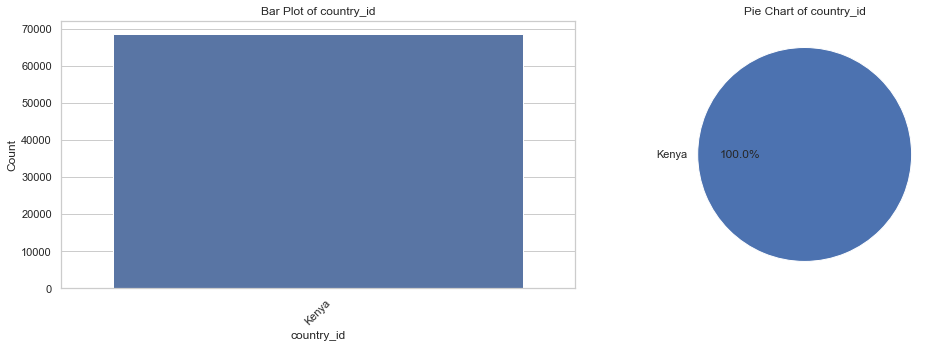

In [ ]:
plot_categorical(train, 'country_id')

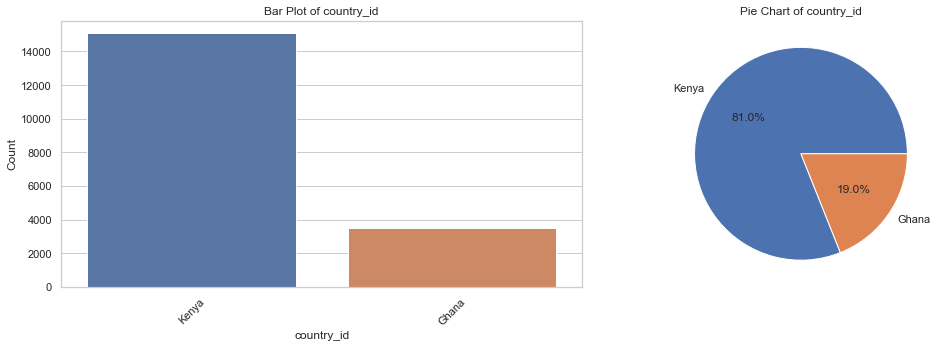

In [ ]:
plot_categorical(test, 'country_id')

##### This shows that test has a new country, ghana so one of the goals is to build a solution that can generalize well in new regions

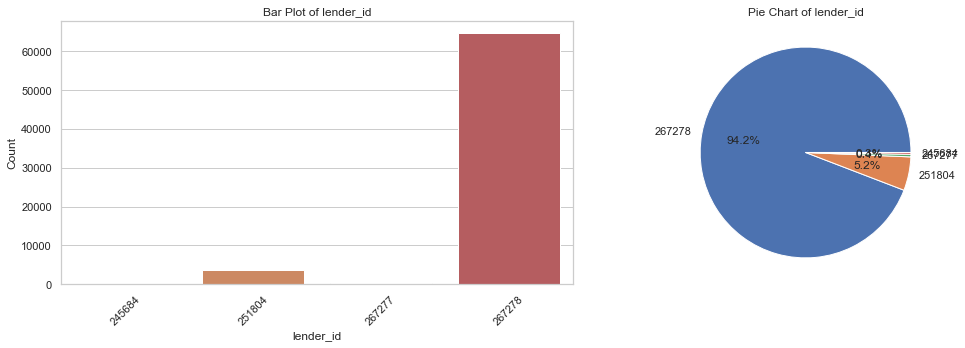

In [ ]:
plot_categorical(train, 'lender_id')

##### You can exploree more of the categorical columns as well

#### TARGET EXPLORATION


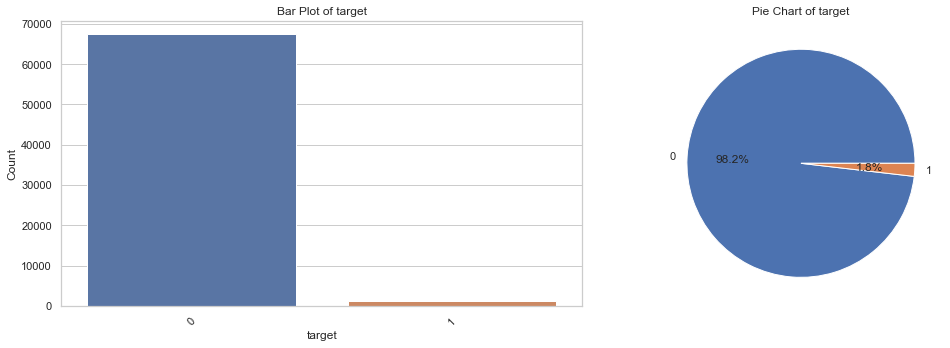

In [ ]:
plot_categorical(train, 'target')

##### You can see the dataset is highly imbalanced , and this is expected in loan default scenarios, So find  ways to deal with the  imbalance

### CONTINUOUS COLUMN EXPLORATION

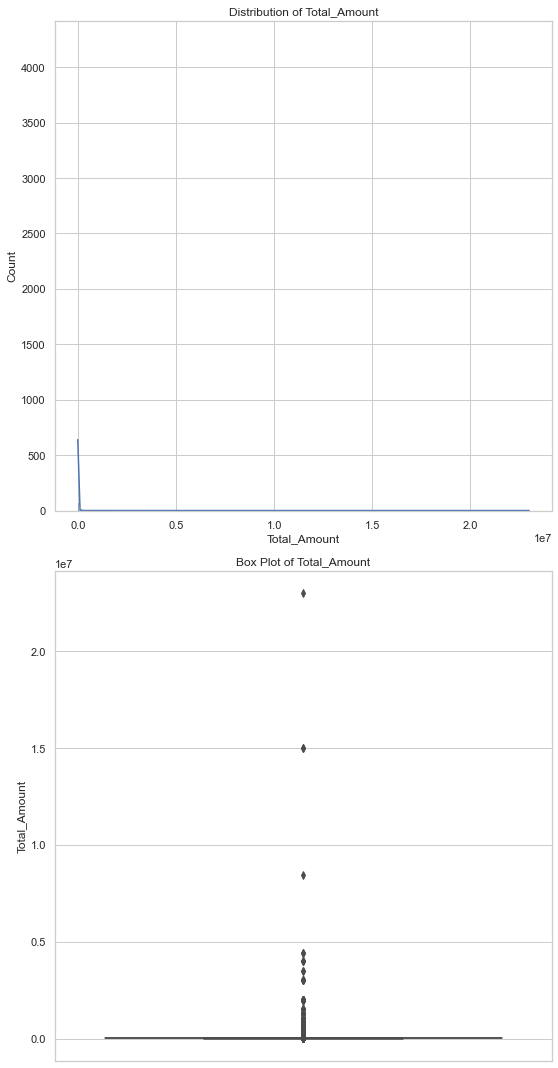

In [ ]:
plot_continuous(train, 'Total_Amount')

Are those outliers?
##### You can explore more of the given numerical columns as well

In [ ]:
nfuqowiefmqwionfmwoidio

NameError: name 'nfuqowiefmqwionfmwoidio' is not defined

### Feature Engineering
* So here we are going to concatenate both the train and test so that we can do the processing once instead of repeating for each

In [ ]:
data = pd.concat([train, test]).reset_index(drop=True)

# Convert the datetime columns appropriately
date_cols = ['disbursement_date', 'due_date']
for col in date_cols:
    data[col] = pd.to_datetime(data[col])
    # Extract month, day, and year from the date columns
    data[col+'_month'] = data[col].dt.month
    data[col+'_day'] = data[col].dt.day
    data[col+'_year'] = data[col].dt.year

# Select all categorical columns from the dataset and label encode them or one hot encode
cat_cols = data.select_dtypes(include='object').columns
num_cols = [col for col in data.select_dtypes(include='number').columns if col not in ['target']]
print(f"The categorical columns are: {cat_cols}.")
print("-"* 100)
print(f"The numerical columns are: {num_cols}")
print("-"* 100)
# we are going to one  hot encode the loan type
data = pd.get_dummies(data, columns=['loan_type'], prefix='loan_type', drop_first=False)
# Convert all the columns with prefix loan_type_ to 0/1 instead of False/True
loan_type_cols = [col for col in data.columns if col.startswith('loan_type_')]
data[loan_type_cols] = data[loan_type_cols].astype(int)

# Label-encoding for the other remaining categorical columns
le = LabelEncoder()
for col in [col for col in cat_cols if col not in ['loan_type', 'ID']]:
    data[col] = le.fit_transform(data[col])


# deal with numerical columns: we saw loan amount is  highly right skewed for this we can log transform it
data['Total_Amount'] = np.log1p(data['Total_Amount']) # study other numerical columns and see if they are skewed as well

# Splitting the data back into train and test
train_df = data[data['ID'].isin(train['ID'].unique())]

test_df = data[data['ID'].isin(test['ID'].unique())]

# we are also going to drop the country id as we saw we have only one country in train
features_for_modelling = [col for col in train_df.columns if col not in date_cols + ['ID', 'target', 'country_id']]

# Check if the new datasets have the same rows as train and test datasets
print(f"The shape of train_df is: {train_df.shape}")
print(f"The shape of test_df is: {test_df.shape}")
print(f"The shape of train is: {train.shape}")
print(f"The shape of test is: {test.shape}")
print(f"The features for modelling are:\n{features_for_modelling}")


The categorical columns are: Index(['ID', 'country_id', 'loan_type', 'New_versus_Repeat', 'source'], dtype='object').
----------------------------------------------------------------------------------------------------
The numerical columns are: ['customer_id', 'tbl_loan_id', 'lender_id', 'Total_Amount', 'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'Lender_portion_to_be_repaid', 'disbursement_date_month', 'disbursement_date_day', 'disbursement_date_year', 'due_date_month', 'due_date_day', 'due_date_year']
----------------------------------------------------------------------------------------------------
The shape of train_df is: (68654, 46)
The shape of test_df is: (18594, 46)
The shape of train is: (68654, 17)
The shape of test is: (18594, 16)
The features for modelling are:
['customer_id', 'tbl_loan_id', 'lender_id', 'Total_Amount', 'Total_Amount_to_Repay', 'duration', 'New_versus_Repeat', 'Amount_Funded_By_Lender', 'Lender_portion_Funded'

### CROSS VALIDATION
* Here we are going to use a simple train test split but due to the imbalance try other robust methods like StratifiedKFold


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_df[features_for_modelling], train['target'], stratify=train['target'], shuffle=True, random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(51490, 41) (17164, 41) (51490,) (17164,)


## Initialisation & Model Training

F1 Score: 0.2616
ROC AUC Score: 0.9285

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96     16849
           1       0.16      0.80      0.26       315

    accuracy                           0.92     17164
   macro avg       0.58      0.86      0.61     17164
weighted avg       0.98      0.92      0.94     17164



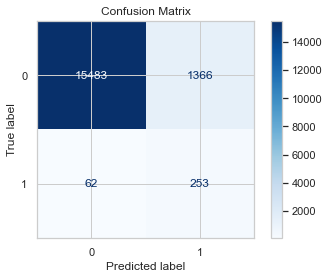

In [ ]:

# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Logistic Regression Classifier
clf = LogisticRegression(
    random_state=42,
    class_weight="balanced",  # Handle class imbalance
)
clf.fit(X_train_scaled, y_train)

# Predictions
y_pred = clf.predict(X_valid_scaled)
y_pred_proba = clf.predict_proba(X_valid_scaled)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

# Confusion Matrix
# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_predictions(
    y_valid,
    y_pred,
    display_labels=clf.classes_,
    cmap=plt.cm.Blues
)
plt.title("Confusion Matrix")
plt.show()


### FEATURE IMPORTANCE

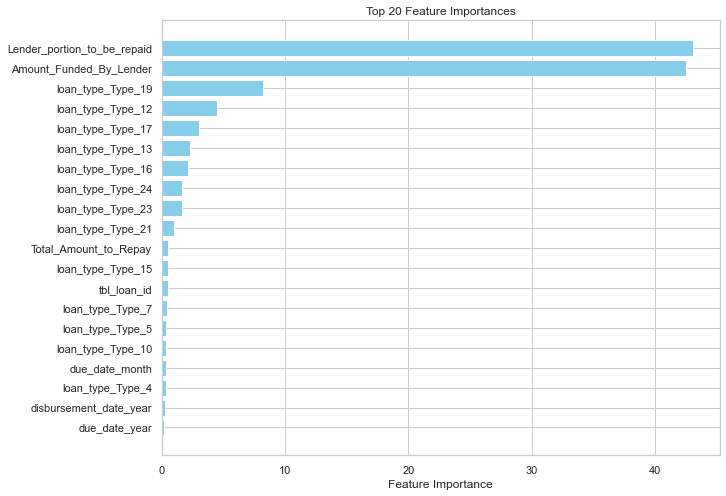

In [ ]:
# Feature Importance

# Get the absolute values of the coefficients
feature_importances = np.abs(clf.coef_).flatten()

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': features_for_modelling,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.show()

## Model Prediction & Inference

In [ ]:
# Make predictions on the test dataset
test_predictions = clf.predict(test_df[features_for_modelling])
test_predictions_proba = clf.predict_proba(test_df[features_for_modelling])[:, 1]

# Save the predictions to a CSV file

test_df['target'] = test_predictions
sub =  test_df[['ID', 'target']]
sub.head()


,ID,target
68654,ID_269404226088267278,0
68655,ID_255356300042267278,0
68656,ID_257026243764267278,0
68657,ID_264617299409267278,0
68658,ID_247613296713267278,0


In [ ]:
sub.to_csv('baseline_submission.csv', index=False)

#### To Do
* Handle imbalance
* Do more feature engineering
* Use more sophisticated machine learning algorithms
##### Good luck

train['target].value_counts()